# **실험3. Activity+Sleep_SMOTE**

In [1]:
import numpy as np
import pandas as pd
import gc
import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, precision_score, f1_score
%matplotlib inline

warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
import statsmodels.api as sm
from imblearn.over_sampling import SMOTE

In [2]:
train_activity = pd.read_csv('train_activity.csv')
train_sleep = pd.read_csv('train_sleep.csv')
train_mmse = pd.read_csv('train_mmse.csv')

In [3]:
training_label = pd.read_csv('training_label_activity.csv')

In [4]:
# EMAIL별 데이터 수 확인
activity_counts = train_activity['EMAIL'].value_counts()
sleep_counts = train_sleep['EMAIL'].value_counts()

# 데이터프레임으로 병합
email_counts = pd.DataFrame({
    'Activity_Counts': activity_counts,
    'Sleep_Counts': sleep_counts,
}).fillna(0)  # 누락된 EMAIL은 0으로 채움

# EMAIL별 데이터 수 출력
print(email_counts)

                  Activity_Counts  Sleep_Counts
EMAIL                                          
nia+068@rowan.kr              120           120
nia+265@rowan.kr              118           118
nia+039@rowan.kr              115           115
nia+059@rowan.kr              113           113
nia+005@rowan.kr              113           113
...                           ...           ...
nia+403@rowan.kr               37            37
nia+394@rowan.kr               36            36
nia+445@rowan.kr               36            36
nia+398@rowan.kr               36            36
nia+015@rowan.kr               35            35

[141 rows x 2 columns]


In [5]:
# 데이터 개수가 동일하지 않은 EMAIL 확인
inconsistent_emails = email_counts[(email_counts['Activity_Counts'] != email_counts['Sleep_Counts'])]

print("데이터 개수가 일치하지 않는 EMAIL:")
print(inconsistent_emails)

데이터 개수가 일치하지 않는 EMAIL:
Empty DataFrame
Columns: [Activity_Counts, Sleep_Counts]
Index: []


activity 데이터와 sleep 데이터의 이메일당 데이터 숫자가 동일함을 확인

In [6]:
train_activity_groupby = train_activity.groupby('EMAIL')
train_activity_agg = pd.DataFrame()

train_sleep_groupby = train_sleep.groupby('EMAIL')
train_sleep_agg = pd.DataFrame()

In [7]:
# datetime 형식으로 변환
train_activity['activity_day_start'] = pd.to_datetime(train_activity['activity_day_start'])
train_activity['activity_day_end'] = pd.to_datetime(train_activity['activity_day_end'])
train_sleep['sleep_bedtime_start'] = pd.to_datetime(train_sleep['sleep_bedtime_start'])
train_sleep['sleep_bedtime_end'] = pd.to_datetime(train_sleep['sleep_bedtime_end'])

# 가장 가까운 sleep 데이터를 찾는 함수
def find_closest_sleep(activity_row, sleep_df):
    activity_time = activity_row['activity_day_end']  # 종료 시간을 기준으로
    sleep_df['time_diff'] = abs(sleep_df['sleep_bedtime_start'] - activity_time)  # 시간 차이 계산
    closest_sleep = sleep_df.loc[sleep_df['time_diff'].idxmin()]  # 가장 작은 시간 차이를 가진 행 반환
    return closest_sleep

# 각 activity 데이터와 가장 가까운 sleep 데이터를 병합
merged_data = []
for _, activity_row in train_activity.iterrows():
    closest_sleep = find_closest_sleep(activity_row, train_sleep)
    merged_data.append({**activity_row.to_dict(), **closest_sleep.to_dict()})

# 병합된 데이터프레임 생성
merged_df = pd.DataFrame(merged_data)

# 결과 확인
print("Merged Data Shape:", merged_df.shape)
merged_df

Merged Data Shape: (9705, 67)


,EMAIL,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_day_end,activity_day_start,activity_high,activity_inactive,...,sleep_score_latency,sleep_score_rem,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,sleep_total,CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),time_diff
0,nia+227@rowan.kr,1.28125,196,2251,...,3353,2020-10-20 03:59:59+09:00,2020-10-19 04:00:00+09:00,0,714,...,75,25,51,-0.22,-0.22,18870,0/46/46/49/47/47/49/47/46/45/46/46/46/46/46/46...,4/2/2/2/1/1/2/2/2/2/1/1/1/1/1/1/1/2/3/3/3/3/2/...,0/63/59/76/75/77/48/71/65/72/64/54/56/58/56/54...,0 days 03:03:16
1,nia+176@rowan.kr,1.25000,145,2159,...,2516,2020-10-21 03:59:59+09:00,2020-10-20 04:00:00+09:00,0,719,...,67,1,24,0.14,0.14,12180,79/79/78/79/85/86/84/81/83/82/85/86/87/85/86/8...,4/2/2/2/1/1/2/2/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/...,39/13/12/18/18/15/14/11/13/14/15/16/17/15/14/1...,0 days 01:44:27
2,nia+139@rowan.kr,1.21875,118,2140,...,1716,2020-10-22 03:59:59+09:00,2020-10-21 04:00:00+09:00,0,708,...,75,42,84,-0.07,-0.07,26880,53/53/53/52/52/52/52/51/51/52/52/52/0/0/51/52/...,4/4/4/4/4/2/2/2/2/2/2/1/4/4/2/2/2/2/2/2/2/2/2/...,19/47/71/25/33/28/48/47/39/28/13/13/0/0/21/17/...,0 days 02:02:30
3,nia+166@rowan.kr,1.28125,180,2240,...,2791,2020-10-23 03:59:59+09:00,2020-10-22 04:00:00+09:00,0,705,...,67,12,33,-0.49,-0.49,14430,47/47/51/51/50/50/47/51/47/47/48/48/49/49/49/5...,2/2/2/2/2/2/2/4/1/1/1/1/1/1/1/1/1/3/3/2/2/2/2/...,26/23/28/23/23/36/22/20/23/24/20/18/20/20/19/2...,0 days 00:35:01
4,nia+219@rowan.kr,1.46875,374,2559,...,5393,2020-10-24 03:59:59+09:00,2020-10-23 04:00:00+09:00,0,437,...,83,14,27,-0.36,-0.36,12930,0/67/65/64/64/63/0/0/64/66/68/69/71/72/69/68/6...,4/2/2/2/2/2/2/1/2/2/2/2/3/2/2/2/2/2/2/2/2/2/3/...,0/26/28/15/14/13/0/0/20/16/11/15/12/11/12/12/1...,0 days 01:43:56
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,nia+383@rowan.kr,1.34375,249,2351,...,4411,2020-12-25 03:59:59+09:00,2020-12-24 04:00:00+09:00,1,780,...,78,52,40,-0.24,-0.24,16140,0/72/71/68/66/63/62/67/62/65/70/69/67/67/66/68...,4/2/2/2/2/2/2/2/2/2/1/2/2/2/2/3/3/2/2/2/1/1/2/...,0/49/38/28/32/41/45/25/39/33/19/22/22/22/28/24...,0 days 00:22:21
9701,nia+014@rowan.kr,1.53125,570,2682,...,11057,2020-12-27 03:59:59+09:00,2020-12-26 04:00:00+09:00,1,518,...,97,3,47,-0.17,-0.17,17790,0/0/0/61/61/60/60/61/62/66/68/68/69/70/69/71/7...,4/4/1/2/2/2/1/1/1/2/1/1/1/1/2/2/2/2/2/2/1/1/1/...,0/0/0/43/46/53/53/46/45/29/21/24/21/22/20/18/1...,0 days 01:35:30
9702,nia+351@rowan.kr,1.34375,295,2331,...,5135,2020-12-28 03:59:59+09:00,2020-12-27 04:00:00+09:00,4,578,...,86,16,29,0.30,0.30,13350,0/0/59/61/61/58/58/58/58/57/57/57/56/57/56/55/...,4/4/1/1/1/2/2/2/2/2/2/2/2/2/2/2/2/2/2/2/1/1/2/...,0/0/32/34/46/49/51/45/54/51/54/66/52/47/51/44/...,0 days 01:02:59
9703,nia+456@rowan.kr,1.31250,186,2280,...,3178,2020-12-29 03:59:59+09:00,2020-12-28 04:00:00+09:00,0,778,...,97,3,42,0.29,0.29,16530,64/64/64/63/62/63/63/64/64/64/64/63/65/65/63/6...,4/4/4/2/1/2/2/1/1/1/1/1/4/4/2/2/2/1/1/1/1/1/2/...,32/31/23/34/38/31/32/31/36/52/32/38/30/29/28/1...,0 days 01:02:28


In [8]:
# 병합 후 데이터 크기
print("Merged Data Shape:", merged_df.shape)

# 누락된 데이터 확인
print(merged_df.isnull().sum())

Merged Data Shape: (9705, 67)
EMAIL                                       0
activity_average_met                        0
activity_cal_active                         0
activity_cal_total                          0
activity_class_5min                         0
                                           ..
sleep_total                                 0
CONVERT(sleep_hr_5min USING utf8)           0
CONVERT(sleep_hypnogram_5min USING utf8)    0
CONVERT(sleep_rmssd_5min USING utf8)        0
time_diff                                   0
Length: 67, dtype: int64


In [9]:
# 'SAMPLE_EMAIL'과 'EMAIL' 매칭을 위해 'train_mmse'의 열 이름 수정
train_mmse.rename(columns={'SAMPLE_EMAIL': 'EMAIL'}, inplace=True)

# 'TOTAL' 및 'DIAG_NM' 병합
merged_df = pd.merge(merged_df, train_mmse[['EMAIL', 'TOTAL', 'DIAG_NM']], on='EMAIL', how='left')

merged_df["DIAG_NM"] = merged_df.DIAG_NM.map({"CN":0, "MCI":0, 'Dem':1})
# 병합 결과 확인
print("Merged Data Shape:", merged_df.shape)
merged_df

Merged Data Shape: (9705, 69)


,EMAIL,activity_average_met,activity_cal_active,activity_cal_total,activity_class_5min,activity_daily_movement,activity_day_end,activity_day_start,activity_high,activity_inactive,...,sleep_score_total,sleep_temperature_delta,sleep_temperature_deviation,sleep_total,CONVERT(sleep_hr_5min USING utf8),CONVERT(sleep_hypnogram_5min USING utf8),CONVERT(sleep_rmssd_5min USING utf8),time_diff,TOTAL,DIAG_NM
0,nia+227@rowan.kr,1.28125,196,2251,...,3353,2020-10-20 03:59:59+09:00,2020-10-19 04:00:00+09:00,0,714,...,51,-0.22,-0.22,18870,0/46/46/49/47/47/49/47/46/45/46/46/46/46/46/46...,4/2/2/2/1/1/2/2/2/2/1/1/1/1/1/1/1/2/3/3/3/3/2/...,0/63/59/76/75/77/48/71/65/72/64/54/56/58/56/54...,0 days 03:03:16,28,0
1,nia+176@rowan.kr,1.25000,145,2159,...,2516,2020-10-21 03:59:59+09:00,2020-10-20 04:00:00+09:00,0,719,...,24,0.14,0.14,12180,79/79/78/79/85/86/84/81/83/82/85/86/87/85/86/8...,4/2/2/2/1/1/2/2/1/1/1/1/1/1/1/1/1/1/1/2/2/2/2/...,39/13/12/18/18/15/14/11/13/14/15/16/17/15/14/1...,0 days 01:44:27,24,0
2,nia+139@rowan.kr,1.21875,118,2140,...,1716,2020-10-22 03:59:59+09:00,2020-10-21 04:00:00+09:00,0,708,...,84,-0.07,-0.07,26880,53/53/53/52/52/52/52/51/51/52/52/52/0/0/51/52/...,4/4/4/4/4/2/2/2/2/2/2/1/4/4/2/2/2/2/2/2/2/2/2/...,19/47/71/25/33/28/48/47/39/28/13/13/0/0/21/17/...,0 days 02:02:30,18,1
3,nia+166@rowan.kr,1.28125,180,2240,...,2791,2020-10-23 03:59:59+09:00,2020-10-22 04:00:00+09:00,0,705,...,33,-0.49,-0.49,14430,47/47/51/51/50/50/47/51/47/47/48/48/49/49/49/5...,2/2/2/2/2/2/2/4/1/1/1/1/1/1/1/1/1/3/3/2/2/2/2/...,26/23/28/23/23/36/22/20/23/24/20/18/20/20/19/2...,0 days 00:35:01,26,0
4,nia+219@rowan.kr,1.46875,374,2559,...,5393,2020-10-24 03:59:59+09:00,2020-10-23 04:00:00+09:00,0,437,...,27,-0.36,-0.36,12930,0/67/65/64/64/63/0/0/64/66/68/69/71/72/69/68/6...,4/2/2/2/2/2/2/1/2/2/2/2/3/2/2/2/2/2/2/2/2/2/3/...,0/26/28/15/14/13/0/0/20/16/11/15/12/11/12/12/1...,0 days 01:43:56,23,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9700,nia+383@rowan.kr,1.34375,249,2351,...,4411,2020-12-25 03:59:59+09:00,2020-12-24 04:00:00+09:00,1,780,...,40,-0.24,-0.24,16140,0/72/71/68/66/63/62/67/62/65/70/69/67/67/66/68...,4/2/2/2/2/2/2/2/2/2/1/2/2/2/2/3/3/2/2/2/1/1/2/...,0/49/38/28/32/41/45/25/39/33/19/22/22/22/28/24...,0 days 00:22:21,27,0
9701,nia+014@rowan.kr,1.53125,570,2682,...,11057,2020-12-27 03:59:59+09:00,2020-12-26 04:00:00+09:00,1,518,...,47,-0.17,-0.17,17790,0/0/0/61/61/60/60/61/62/66/68/68/69/70/69/71/7...,4/4/1/2/2/2/1/1/1/2/1/1/1/1/2/2/2/2/2/2/1/1/1/...,0/0/0/43/46/53/53/46/45/29/21/24/21/22/20/18/1...,0 days 01:35:30,28,0
9702,nia+351@rowan.kr,1.34375,295,2331,...,5135,2020-12-28 03:59:59+09:00,2020-12-27 04:00:00+09:00,4,578,...,29,0.30,0.30,13350,0/0/59/61/61/58/58/58/58/57/57/57/56/57/56/55/...,4/4/1/1/1/2/2/2/2/2/2/2/2/2/2/2/2/2/2/2/1/1/2/...,0/0/32/34/46/49/51/45/54/51/54/66/52/47/51/44/...,0 days 01:02:59,30,0
9703,nia+456@rowan.kr,1.31250,186,2280,...,3178,2020-12-29 03:59:59+09:00,2020-12-28 04:00:00+09:00,0,778,...,42,0.29,0.29,16530,64/64/64/63/62/63/63/64/64/64/64/63/65/65/63/6...,4/4/4/2/1/2/2/1/1/1/1/1/4/4/2/2/2/1/1/1/1/1/2/...,32/31/23/34/38/31/32/31/36/52/32/38/30/29/28/1...,0 days 01:02:28,27,0


### **validation data에도 똑같은 작업수행**

In [10]:
val_activity = pd.read_csv('val_activity.csv')
val_sleep = pd.read_csv('val_sleep.csv')
val_mmse = pd.read_csv('val_mmse.csv')

In [11]:
# datetime 형식으로 변환
val_activity['activity_day_start'] = pd.to_datetime(val_activity['activity_day_start'])
val_activity['activity_day_end'] = pd.to_datetime(val_activity['activity_day_end'])
val_sleep['sleep_bedtime_start'] = pd.to_datetime(val_sleep['sleep_bedtime_start'])
val_sleep['sleep_bedtime_end'] = pd.to_datetime(val_sleep['sleep_bedtime_end'])

# 가장 가까운 sleep 데이터를 찾는 함수
def find_closest_sleep(activity_row, sleep_df):
    activity_time = activity_row['activity_day_end']  # 종료 시간을 기준으로
    sleep_df['time_diff'] = abs(sleep_df['sleep_bedtime_start'] - activity_time)  # 시간 차이 계산
    closest_sleep = sleep_df.loc[sleep_df['time_diff'].idxmin()]  # 가장 작은 시간 차이를 가진 행 반환
    return closest_sleep

# 각 activity 데이터와 가장 가까운 sleep 데이터를 병합
merged_val_data = []
for _, activity_row in val_activity.iterrows():
    closest_sleep = find_closest_sleep(activity_row, val_sleep)
    merged_val_data.append({**activity_row.to_dict(), **closest_sleep.to_dict()})

# 병합된 validation 데이터프레임 생성
merged_val_df = pd.DataFrame(merged_val_data)

In [12]:
# 'SAMPLE_EMAIL'을 'EMAIL'로 변경하여 매칭
val_mmse.rename(columns={'SAMPLE_EMAIL': 'EMAIL'}, inplace=True)

# 'TOTAL' 및 'DIAG_NM' 병합
merged_val_df = pd.merge(merged_val_df, val_mmse[['EMAIL', 'TOTAL', 'DIAG_NM']], on='EMAIL', how='left')

# 중복된 열 제거 및 이름 정리
merged_val_df = merged_val_df.drop(columns=['TOTAL_x', 'DIAG_NM_x'], errors='ignore')
merged_val_df.rename(columns={'TOTAL_y': 'TOTAL', 'DIAG_NM_y': 'DIAG_NM'}, inplace=True)

In [13]:
# 데이터 크기 확인
print("Merged Validation Data Shape:", merged_val_df.shape)

# 누락된 데이터 확인
print(merged_val_df.isnull().sum())

Merged Validation Data Shape: (2478, 69)
EMAIL                                       0
activity_average_met                        0
activity_cal_active                         0
activity_cal_total                          0
activity_class_5min                         0
                                           ..
CONVERT(sleep_hypnogram_5min USING utf8)    0
CONVERT(sleep_rmssd_5min USING utf8)        0
time_diff                                   0
TOTAL                                       0
DIAG_NM                                     0
Length: 69, dtype: int64


In [14]:
merged_val_df["DIAG_NM"] = merged_val_df.DIAG_NM.map({"CN":0, "MCI":0, 'Dem':1})

In [15]:
object_columns = merged_df.select_dtypes(include=['object']).columns
merged_df = merged_df.drop(columns=object_columns)

object_columns = merged_val_df.select_dtypes(include=['object']).columns
merged_val_df = merged_val_df.drop(columns=object_columns)

In [16]:
columns_to_drop = ['time_diff', 'activity_day_end', 'activity_day_start', 'sleep_bedtime_end', 'sleep_bedtime_start']
merged_df = merged_df.drop(columns=columns_to_drop, errors='ignore')
merged_val_df = merged_val_df.drop(columns=columns_to_drop, errors='ignore')

In [17]:
merged_df['DIAG_NM'].value_counts()

DIAG_NM
0    8214
1    1491
Name: count, dtype: int64

**target의 분포확인**

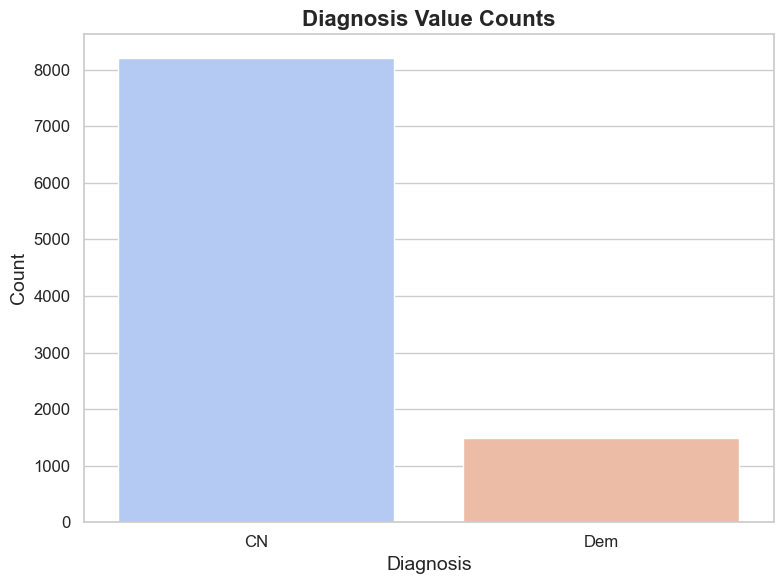

In [18]:
# 데이터
labels = ['CN', 'Dem']
values = [
    merged_df[merged_df['DIAG_NM'] == 0].shape[0],  # 'CN' 클래스 개수
    merged_df[merged_df['DIAG_NM'] == 1].shape[0]   # 'Dem' 클래스 개수
]

# 스타일 설정
sns.set_theme(style="whitegrid")
palette = sns.color_palette("coolwarm", len(values))

# 그래프 그리기
plt.figure(figsize=(8, 6))
sns.barplot(x=labels, y=values, palette=palette)

# 그래프 세부 설정
plt.xlabel('Diagnosis', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Diagnosis Value Counts', fontsize=16, fontweight='bold')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

### **랜덤포레스트로 중요한 피쳐 확인하기**

                              Feature  Importance
38                     sleep_restless    0.105221
43           sleep_score_disturbances    0.074872
33            sleep_midpoint_at_delta    0.063857
30                    sleep_hr_lowest    0.063043
29                   sleep_hr_average    0.058646
32                        sleep_light    0.054566
42                   sleep_score_deep    0.047479
45                sleep_score_latency    0.045433
25               sleep_breath_average    0.041498
41              sleep_score_alignment    0.040929
39                        sleep_rmssd    0.035955
27                     sleep_duration    0.033253
37                          sleep_rem    0.030042
46                    sleep_score_rem    0.028280
50                        sleep_total    0.028010
44             sleep_score_efficiency    0.026919
35                sleep_onset_latency    0.025040
26                         sleep_deep    0.025008
49        sleep_temperature_deviation    0.024615


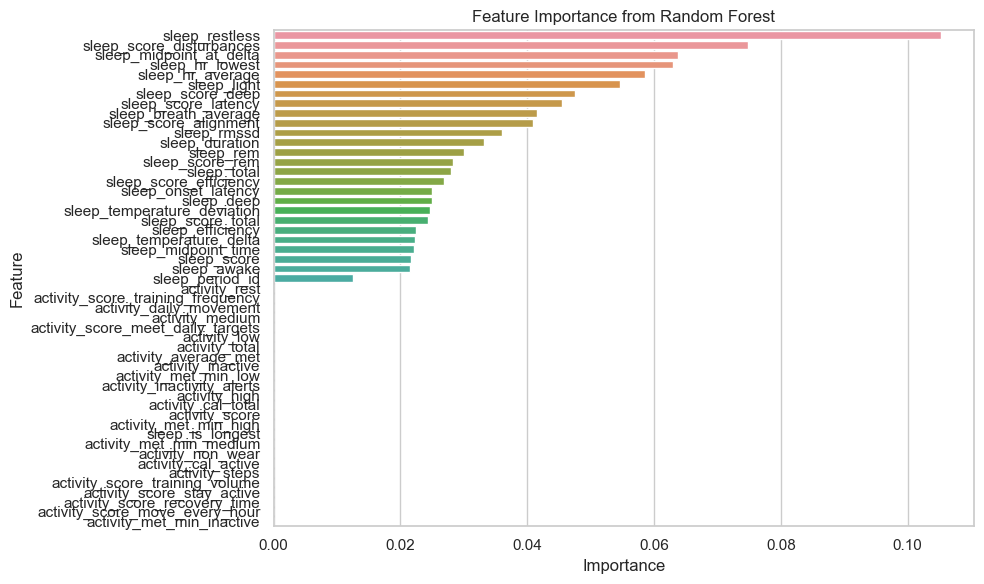

Validation Accuracy: 0.98


In [19]:
# DIAG_NM을 종속 변수로 설정하고 독립 변수와 분리
X_train = merged_df.drop(columns=['DIAG_NM', 'TOTAL'])
y_train = merged_df['DIAG_NM']

# 랜덤포레스트 모델 학습
rf_model = RandomForestClassifier(random_state=42, n_estimators=100)
rf_model.fit(X_train, y_train)

# 중요한 피처 추출
feature_importances = rf_model.feature_importances_

# 피처 중요도를 데이터프레임으로 정리
importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# 결과 출력
print(importance_df)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title('Feature Importance from Random Forest')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

# 검증 데이터로 예측 정확도 확인 (선택 사항)
X_val = merged_val_df.drop(columns=['DIAG_NM', 'TOTAL'])
y_val = merged_val_df['DIAG_NM']
y_pred = rf_model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.2f}")

### **상위 중요도 피쳐만을 이용해서 로지스틱 회귀 수행**

In [20]:
top_features = [
    "sleep_restless", "sleep_score_disturbances", 
    "sleep_midpoint_at_delta", 
    "sleep_hr_lowest", "sleep_light", "sleep_hr_average"
]

# target은 종속 변수 (0/1 값), features는 독립 변수
X_train = merged_df[top_features]
y_train = merged_df["DIAG_NM"]
X_test = merged_val_df[top_features]
y_test = merged_val_df["DIAG_NM"]

In [21]:
X_train_const = sm.add_constant(X_train)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.230838
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                DIAG_NM   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9698
Method:                           MLE   Df Model:                            6
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.4619
Time:                        17:23:17   Log-Likelihood:                -2240.3
converged:                       True   LL-Null:                       -4163.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -7.3841      0.591    -12.491      0.000      -8.543

In [22]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.735270379338176
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.84      2404
           1       0.06      0.58      0.12        74

    accuracy                           0.74      2478
   macro avg       0.52      0.66      0.48      2478
weighted avg       0.96      0.74      0.82      2478

Confusion Matrix:
 [[1779  625]
 [  31   43]]


# **- 추가 : TOTAL 변수 포함 예측 -**

In [23]:
top_features = [
    'TOTAL', "sleep_restless", "sleep_score_disturbances", 
    "sleep_midpoint_at_delta", 
    "sleep_hr_lowest", "sleep_light", "sleep_hr_average"
]

# target은 종속 변수 (0/1 값), features는 독립 변수
X_train = merged_df[top_features]
y_train = merged_df["DIAG_NM"]
X_test = merged_val_df[top_features]
y_test = merged_val_df["DIAG_NM"]

In [24]:
X_train_const = sm.add_constant(X_train)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.181213
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:                DIAG_NM   No. Observations:                 9705
Model:                          Logit   Df Residuals:                     9697
Method:                           MLE   Df Model:                            7
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.5776
Time:                        17:23:17   Log-Likelihood:                -1758.7
converged:                       True   LL-Null:                       -4163.0
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        5.4386      0.811      6.705      0.000       3.849

In [25]:
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train, y_train)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.9523809523809523
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.95      0.97      2404
           1       0.39      1.00      0.56        74

    accuracy                           0.95      2478
   macro avg       0.69      0.98      0.77      2478
weighted avg       0.98      0.95      0.96      2478

Confusion Matrix:
 [[2286  118]
 [   0   74]]


# **- 추가 : SMOTE 적용 -**

In [26]:
top_features = [
    "sleep_restless", "sleep_score_disturbances", 
    "sleep_midpoint_at_delta", 
    "sleep_hr_lowest", "sleep_light", "sleep_hr_average"
]

# target은 종속 변수 (0/1 값), features는 독립 변수
X_train = merged_df[top_features]
y_train = merged_df["DIAG_NM"]
X_test = merged_val_df[top_features]
y_test = merged_val_df["DIAG_NM"]

smote = SMOTE(random_state=0)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print('SMOTE 적용 전 학습용 피처/레이블 데이터 세트: ', X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트: ', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 레이블 값 분포: \n', pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트:  (9705, 6) (9705,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트:  (16428, 6) (16428,)
SMOTE 적용 후 레이블 값 분포: 
 DIAG_NM
0    8214
1    8214
Name: count, dtype: int64


In [27]:
# 상수항 추가 (Intercept)
X_train_const = sm.add_constant(X_train_over)

# 로지스틱 회귀 모델 학습
logit_model = sm.Logit(y_train_over, X_train_const)
result = logit_model.fit()

# 결과 출력
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.360420
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                DIAG_NM   No. Observations:                16428
Model:                          Logit   Df Residuals:                    16421
Method:                           MLE   Df Model:                            6
Date:                Sat, 14 Dec 2024   Pseudo R-squ.:                  0.4800
Time:                        17:23:17   Log-Likelihood:                -5921.0
converged:                       True   LL-Null:                       -11387.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                       -3.9516      0.381    -10.383      0.000      -4.698

In [28]:
# 로지스틱 회귀 모델 초기화 및 학습
logistic_model = LogisticRegression(max_iter=1000, class_weight='balanced')  # class_weight='balanced'로 클래스 불균형 처리
logistic_model.fit(X_train_over, y_train_over)

# 검증 데이터 예측
y_pred = logistic_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Logistic Regression Accuracy:", accuracy)

# 분류 리포트 출력
print("Classification Report:\n", classification_report(y_test, y_pred))

# 혼동 행렬 출력
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Logistic Regression Accuracy: 0.735270379338176
Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.74      0.84      2404
           1       0.06      0.58      0.12        74

    accuracy                           0.74      2478
   macro avg       0.52      0.66      0.48      2478
weighted avg       0.96      0.74      0.82      2478

Confusion Matrix:
 [[1779  625]
 [  31   43]]
